In [17]:
import json
import re
with open('/Users/pranathi/Library/CloudStorage/OneDrive-ErasmusUniversityRotterdam/Masters/computer_science/TVs-all-merged.json', 'r') as file:
    data = json.load(file)
    


all_values = [item for sublist in data.values() for item in sublist]    
all_values_dict = {i: item for i, item in enumerate(all_values)}

def clean_all_values_dict_advanced(all_values_dict, remove_shops=True):
   
    def clean_text(text, remove_shops=True):
        if not isinstance(text, str):
            return text
        
        cleaned = text.lower()  # Lowercase first
        
        
        cleaned = re.sub(r'\s+', '', cleaned)  # Remove all spaces early
        
        
        inch_patterns = [
            (r'[\'"]{1,2}', 'inch'),           # " or ' or '' → inch
            (r'-inch', 'inch'),                 # -inch → inch (no \b needed after space removal)
            (r'inches', 'inch'),                # inches → inch
            (r'(\d+)in(?=\d|$)', r'\1inch'),    # 40in → 40inch (standalone "in")
        ]
        for pattern, replacement in inch_patterns:
            cleaned = re.sub(pattern, replacement, cleaned)
        
        # =====================================================================
        # STEP 3: Normalize HERTZ variations (simplified)
        # =====================================================================
        hz_patterns = [
            (r'hertz', 'hz'),                   # hertz → hz
            (r'-hz', 'hz'),                     # -hz → hz
        ]
        for pattern, replacement in hz_patterns:
            cleaned = re.sub(pattern, replacement, cleaned)
        
        # =====================================================================
        # STEP 4: Normalize RESOLUTION patterns (simplified)
        # =====================================================================
        resolution_patterns = [
            (r'4k', '2160p'),                   # 4k → 2160p
            (r'uhd', '2160p'),                  # uhd → 2160p
            (r'fullhd', '1080p'),               # fullhd → 1080p (spaces already removed)
            (r'hd(?=tv)', '720p'),              # hd before tv → 720p (but keep hdtv)
        ]
        for pattern, replacement in resolution_patterns:
            cleaned = re.sub(pattern, replacement, cleaned)
        
        # =====================================================================
        # STEP 5: Normalize LED/LCD/PLASMA/OLED (simplified)
        # =====================================================================
        display_patterns = [
            (r'led-lcd', 'led'),                # led-lcd → led
            (r'lcd/led', 'led'),                # lcd/led → led
            (r'led/lcd', 'led'),                # led/lcd → led
        ]
        for pattern, replacement in display_patterns:
            cleaned = re.sub(pattern, replacement, cleaned)
        
        # =====================================================================
        # STEP 6: Remove shop/website-specific noise (OPTIONAL)
        # =====================================================================
        # Only remove shops if remove_shops=True
        if remove_shops:
            website_noise = [
                # Main 4 shops - with domain extensions (most specific)
                r'newegg\.?com',
                r'amazon\.?com',
                r'bestbuy\.?com',
                r'best-buy\.?com',
                r'thenerds\.?net',
                # Other common shops
                
                # Shop names as standalone words (word boundaries)
                r'\bnewegg\b',
                r'\bamazon\b',
                r'\bbestbuy\b',
                r'\bbest\s*buy\b',
                r'\bthenerds\b',
                # Shop names at start/end (even without word boundaries after space removal)
                r'^newegg',
                r'^amazon',
                r'^bestbuy',
                r'^bestbuy',
                r'^thenerds',
                r'newegg$',
                r'amazon$',
                r'bestbuy$',  # Catches "bestbuy" at end (common pattern)
                r'bestbuy$',
                r'thenerds$',
                # Common prefixes/suffixes
                r'^refurbished:?',
                r'^certifiedrefurbished:?',
                r'-best\s*buy',
                r'-newegg',
                r'-amazon',
                r'best\s*buy$',
            ]
            for pattern in website_noise:
                cleaned = re.sub(pattern, '', cleaned, flags=re.IGNORECASE)
            
            # Additional cleanup: Remove any remaining shop fragments
            # This catches cases where shop name got partially removed or concatenated
            shop_fragments = ['newegg', 'amazon', 'bestbuy', 'thenerds']
            for fragment in shop_fragments:
                # Remove if it appears as a standalone word or at boundaries
                # This is especially important after space removal when shop names get concatenated
                cleaned = re.sub(rf'\b{fragment}\b', '', cleaned, flags=re.IGNORECASE)
                cleaned = re.sub(rf'^{fragment}', '', cleaned, flags=re.IGNORECASE)
                cleaned = re.sub(rf'{fragment}$', '', cleaned, flags=re.IGNORECASE)
        
        # =====================================================================
        # STEP 7: Remove noise characters (punctuation, special chars)
        # =====================================================================
        cleaned = re.sub(r'[^\w]', '', cleaned)  # Remove all non-alphanumeric
        
        return cleaned
    
    def clean_dict(d, remove_shops=True):
        cleaned = {}
        for k, v in d.items():
            # SKIP modelID completely - preserve original key and value
            if k.lower() == 'modelid':
                cleaned[k] = v
                continue
            
            key_clean = clean_text(k, remove_shops=remove_shops)
            if isinstance(v, str):
                cleaned[key_clean] = clean_text(v, remove_shops=remove_shops)
            elif isinstance(v, dict):
                cleaned[key_clean] = clean_dict(v, remove_shops=remove_shops)
            else:
                cleaned[key_clean] = v
        return cleaned
    
    return {idx: clean_dict(item, remove_shops=remove_shops) for idx, item in all_values_dict.items()}



Functions

In [18]:
import numpy as np
from sklearn.utils import resample

def bootstrap_train_test_split(n_samples):
    
    # Draw bootstrap sample with replacement using sklearn
    train_indices = resample(range(n_samples), n_samples=n_samples, 
                            replace=True)
    train_indices = np.array(train_indices)
    
    # Out-of-sample instances (not selected in bootstrap)
    all_indices = set(range(n_samples))
    train_set = set(train_indices)
    test_indices = np.array(sorted(all_indices - train_set))
    
    return train_indices, test_indices

def run_bootstrap_iterations(n_samples, n_bootstraps=5):
    
    bootstrap_splits = []
    
    for i in range(n_bootstraps):
        train_idx, test_idx = bootstrap_train_test_split(n_samples)
        bootstrap_splits.append((train_idx, test_idx))
        
        if (i + 1) % 10 == 0 or i == 0:
            train_pct = len(np.unique(train_idx)) / n_samples * 100
            test_pct = len(test_idx) / n_samples * 100
            print(f"Bootstrap {i+1}/{n_bootstraps}: "
                  f"{len(np.unique(train_idx))} unique train ({train_pct:.1f}%), "
                  f"{len(test_idx)} test ({test_pct:.1f}%)")
    
    return bootstrap_splits

def apply_bootstrap_to_data(data, train_indices, test_indices):
    
    if isinstance(data, np.ndarray):
        train_data = data[train_indices]
        test_data = data[test_indices]
    elif isinstance(data, list):
        train_data = [data[i] for i in train_indices]
        test_data = [data[i] for i in test_indices]
    else:  # Assume pandas DataFrame/Series
        train_data = data.iloc[train_indices]
        test_data = data.iloc[test_indices]
    
    return train_data, test_data


In [19]:

import re

def split_and_extract_model_words(title):
    title = title.lower()

    # 1) Find base model tokens containing both letters and digits
    base_pattern = r"[a-z0-9]*(([0-9]+[^0-9,\s]+)|([^0-9,\s]+[0-9]+))[a-z0-9]*"
    base_tokens = [m.group(0) for m in re.finditer(base_pattern, title)]

    refined_tokens = []
    for tok in base_tokens:
        # 2) Split token further into pieces at digit/letter boundaries
        #    e.g. "32inch720p" -> ["32inch", "720p"]
        parts = re.findall(r"[0-9]+[a-z]+|[a-z]+[0-9]+|[0-9]+|[a-z]+", tok)
        # keep only parts that contain both letters and digits (model-like)
        for p in parts:
            if re.search(r"[a-z]", p) and re.search(r"[0-9]", p):
                refined_tokens.append(p)

    return {"model_words": refined_tokens}




def extract_model_words_from_title(title):
   
    if not isinstance(title, str):
        return set()
    
    title = title.lower()
    
    # Paper's pattern for title model words
    base_pattern = r"[a-z0-9]*(([0-9]+[^0-9,\s]+)|([^0-9,\s]+[0-9]+))[a-z0-9]*"
    base_tokens = [m.group(0) for m in re.finditer(base_pattern, title)]
    
    refined_tokens = []
    for tok in base_tokens:
        # Split token further at digit/letter boundaries
        parts = re.findall(r"[0-9]+[a-z]+|[a-z]+[0-9]+|[0-9]+|[a-z]+", tok)
        for p in parts:
            if re.search(r"[a-z]", p) and re.search(r"[0-9]", p):
                refined_tokens.append(p)
    
    return set(refined_tokens)


def extract_model_words_from_value(value):
    
    if not isinstance(value, str):
        return set()
    
    value = value.lower().strip()
    model_words = set()
    
    # Split by common separators to handle composite values like "36.8inchx24.4inch"
    parts = re.split(r'[x×\(\)]', value)
    
    for part in parts:
        part = part.strip()
        if not part:
            continue
            
        # Pattern: decimal number with optional alphabetic suffix
        # Match: "19.2lb", "40inch", "120hz", "1080p", "19.5", "120"
        match = re.match(r'^(\d+(?:\.\d+)?)[a-z]*$', part)
        if match:
            # Extract only the numeric part (remove non-numeric suffix)
            numeric_part = match.group(1)
            model_words.add(numeric_part)
    
    return model_words


def extract_all_model_words_paper_method(item):
    """
    Extract model words from brands, title, and the number 1080.
    
    1. MW_title: Extract from title only
    2. MW_brand: Extract brand name as a model word
    3. MW_1080: Extract "1080" if it appears in the title
    
    Returns union of all model words.
    """
    mw_title = set()
    mw_brand = set()
    mw_1080 = set()
    
    # Step 1: Extract MW_title from title
    title = item.get('title', '') or ''
    mw_title.update(extract_model_words_from_title(title))
    
    # Step 2: Extract brand as a model word
    # Brand is critical for matching - products with same brand are more likely duplicates
    brand_list = [
        "samsung", "lg", "sony", "philips", "panasonic", "sharp", "toshiba",
        "vizio", "hisense", "tcl", "insignia", "sanyo", "magnavox", "westinghouse",
        "element", "rca", "haier", "funai", "sceptre", "proscan", "coby",
        "supersonic", "naxa", "dynex", "emerson", "sylvania", "jvc", "hitachi"
    ]
    
    # Check title for brand
    title_lower = title.lower()
    for brand in brand_list:
        if brand in title_lower:
            mw_brand.add(brand)
            break  # Only add first matching brand
    
    # Step 3: Extract "1080" from title if present
    # Look for "1080" as a standalone number or as part of "1080p"
    if re.search(r'1080', title_lower):
        mw_1080.add('1080')
    
    # Return union of all sets (title, brand, and 1080 model words)
    # Filter out pure numeric strings (except 1080 which we want to keep)
    all_mw = mw_title | mw_brand | mw_1080
    # Keep 1080 but filter out other pure numeric strings
    filtered_mw = [mw for mw in all_mw if mw == '1080' or not re.match(r'^\d+(\.\d+)?$', mw)]
    return filtered_mw




In [20]:

def create_binary_vectors(titles_model_words, vocab, word_to_index):
    binary_vectors = []
    for words in titles_model_words:
        vector = [0] * len(vocab)
        for word in words:
            if word in word_to_index:
                vector[word_to_index[word]] = 1
        binary_vectors.append(vector)
    
    P = np.array(binary_vectors)
    print(f"Binary vectors shape: {P.shape}")
    return P


In [21]:
def next_prime(n):
    if n <= 2:
        return 2
    n = n if n % 2 != 0 else n + 1  # Make odd
    while True:
        is_prime = True
        for i in range(3, int(n**0.5) + 1, 2):
            if n % i == 0:
                is_prime = False
                break
        if is_prime:
            return n
        n += 2

In [22]:
def compute_minhash_signatures(P, n_hash_functions=None):
    num_products, vocab_size = P.shape
    
    if n_hash_functions is None:
        n = int(0.4* vocab_size)  # Increased from 0.4 to 0.5
        n = max(n, 2)
    
    # Choose large prime p > vocab_size
    p = next_prime(vocab_size * vocab_size + 1)  # Ensure p > vocab_size^2
    m = vocab_size
    
    print(f"Using p={p}, hash_functions={n}, vocab_size={vocab_size}")
    
    # Generate a,b pairs for n hash functions
    a_params = np.random.randint(1, p, size=n)
    b_params = np.random.randint(0, p, size=n)
    
    # OPTIMIZATION: Use full prime range instead of vocab_size to reduce collisions
    max_hash_value = p - 1
    S = np.full((n, num_products), max_hash_value, dtype=np.int64)
    
    non_zero_positions = [np.where(P[v] == 1)[0] for v in range(num_products)]
    
    for i in range(n):
        a, b = a_params[i], b_params[i]
        for v in range(num_products):
            product_set = non_zero_positions[v]
            
            if len(product_set) > 0:
                # Use only % p which gives range [0, p-1] instead of [0, vocab_size-1]
                hashes = ((a * product_set + b) % p)
                min_hash = np.min(hashes)
                S[i, v] = min_hash
            
    S_normalized = (S % vocab_size).astype(int)
    
    print(f"Signature matrix shape: {S_normalized.shape}")
    return S_normalized, (a_params, b_params, p, vocab_size)


In [23]:
def count_true_duplicates_in_candidates(dict_data, candidate_pairs, return_set=False):
    from collections import defaultdict
    
    # Build ground truth clusters from modelID
    modelID_to_indices = defaultdict(list)
    for idx, item in dict_data.items():
        if 'modelID' in item:
            modelID_to_indices[item['modelID']].append(idx)
    
    # Keep only modelIDs with 2+ products (actual duplicates)
    duplicate_clusters = {mid: set(idxs) for mid, idxs in modelID_to_indices.items() if len(idxs) > 1}
    
    # Find true duplicates within candidate_pairs
    true_duplicates_in_candidates = set()
    for i, j in candidate_pairs:
        a, b = sorted((i, j))
        for cluster in duplicate_clusters.values():
            if a in cluster and b in cluster:
                true_duplicates_in_candidates.add((a, b))
                break
    
    n_true_duplicates = len(true_duplicates_in_candidates)
    
    if return_set:
        return n_true_duplicates, true_duplicates_in_candidates
    else:
        return n_true_duplicates


# Example usage:
# n_true = count_true_duplicates_in_candidates(dict_test, candidate_pairs)
# n_true, true_set = count_true_duplicates_in_candidates(dict_test, candidate_pairs, return_set=True)


In [24]:
# ============================================================================
# FUNCTION: Find Best Threshold Using F1 Score on Training Set
# ============================================================================
def find_best_threshold_on_training_set(dict_train, model_words_train, vocab, word_to_index, 
                                        thresholds=[0.4, 0.5], f1_range=(0.0, 0.2), verbose=True):
    
    from collections import defaultdict
    
    if verbose:
        print("\n" + "="*70)
        print("FINDING BEST THRESHOLD ON TRAINING SET")
        print("="*70)
        f1_max = f1_range[1] if isinstance(f1_range, tuple) else f1_range
        print(f"F1 score upper bound constraint: F1 <= {f1_max:.2f}")
        print(f"Testing thresholds: {thresholds}")
        print(f"Training set size: {len(dict_train)} products")
    
    # Build ground truth for training set
    modelID_to_indices_train = defaultdict(list)
    for idx, item in dict_train.items():
        if 'modelID' in item:
            modelID_to_indices_train[item['modelID']].append(idx)
    
    # Keep only modelIDs with 2+ products (actual duplicates)
    duplicate_clusters_train = {mid: set(idxs) for mid, idxs in modelID_to_indices_train.items() if len(idxs) > 1}
    
    # Calculate total true duplicate pairs in training set
    total_true_pairs_train = sum(len(idxs) * (len(idxs) - 1) // 2 for idxs in duplicate_clusters_train.values())
    
    if verbose:
        print(f"Total true duplicate pairs in training set: {total_true_pairs_train}")
        print(f"Duplicate clusters: {len(duplicate_clusters_train)}")
        print("\nTesting thresholds...")
        print(f"{'Threshold':<12} {'Candidates':<12} {'TP':<6} {'PQ':<10} {'PC':<10} {'F1':<10}")
        print("-" * 70)
    
    # Test each threshold
    threshold_results = {}
    best_threshold = None
    best_f1 = -1
    
    # Create binary vectors and MinHash signatures once (same for all thresholds)
    A_train = create_binary_vectors(model_words_train, vocab, word_to_index)
    L_train, _ = compute_minhash_signatures(A_train)
    product_ids_train = list(dict_train.keys())
    n_hash_functions = L_train.shape[0]
    
    if verbose:
        print(f"Signature matrix shape: {L_train.shape}")
        print(f"Number of hash functions: {n_hash_functions}")
    
    for t in thresholds:
        if verbose:
            print(f"\nTesting threshold {t}...")
        
        # Calculate (b, r) for this threshold using theoretical formula: t = (1/b)^(1/r)
        # Subject to constraint: b * r == n_hash_functions
        best_b, best_r = optimize_lsh_parameters(n_hash_functions, t, min_prob=0.5)
        
        if verbose:
            t_achieved = (1 / best_b) ** (1 / best_r)
            print(f"    Theoretical (b, r) = ({best_b}, {best_r}) for threshold {t}")
            print(f"    Achieved threshold: {t_achieved:.6f} (error: {abs(t - t_achieved):.6f})")
        
        # Run LSH with theoretical (b, r) for this threshold
        candidate_pairs = lsh_banding(L_train, product_ids_train, t=t, b=best_b, r=best_r, verbose=False)
        
        # Count true duplicates using the function
        TP = count_true_duplicates_in_candidates(dict_train, candidate_pairs)
        
        # Calculate metrics
        PQ = TP / len(candidate_pairs) if len(candidate_pairs) > 0 else 0.0
        PC = TP / total_true_pairs_train if total_true_pairs_train > 0 else 0.0
        F1 = 2 * (PQ * PC) / (PQ + PC) if (PQ + PC) > 0 else 0.0
        
        threshold_results[t] = {
            'candidate_pairs': len(candidate_pairs),
            'TP': TP,
            'PQ': PQ,
            'PC': PC,
            'F1': F1,
            'best_b': best_b,
            'best_r': best_r
        }
        
        if verbose:
            f1_max = f1_range[1] if isinstance(f1_range, tuple) else f1_range
            f1_status = "✓" if F1 <= f1_max else "✗"
            print(f"{t:<12.2f} {len(candidate_pairs):<12} {TP:<6} {PQ:<10.6f} {PC:<10.6f} {F1:<10.6f} (b={best_b}, r={best_r}) {f1_status}")
        
        # Update best threshold (only if F1 <= f1_max)
        f1_max = f1_range[1] if isinstance(f1_range, tuple) else f1_range
        if F1 <= f1_max and F1 > best_f1:
            best_f1 = F1
            best_threshold = t
    
    if verbose:
        print("-" * 70)
        if best_threshold is not None:
            f1_max = f1_range[1] if isinstance(f1_range, tuple) else f1_range
            if best_f1 <= f1_max:
                print(f"\nBest threshold: {best_threshold} (F1 = {best_f1:.6f}) [F1 <= {f1_max:.2f} ✓]")
            else:
                print(f"\nBest threshold: {best_threshold} (F1 = {best_f1:.6f}) [F1 > {f1_max:.2f} ✗ - no threshold found with F1 <= {f1_max:.2f}]")
        else:
            print(f"\nNo valid threshold found!")
        print("="*70)
    
    return best_threshold, best_f1, threshold_results

def find_best_lsh_bands_rows_for_threshold(L_train, product_ids_train, dict_train, threshold, 
                                          n_hash_functions, max_configs=30, f1_range=(0.0, 0.2), verbose=True):
   
    from collections import defaultdict
    import numpy as np
    
    # Build ground truth for training set
    modelID_to_indices_train = defaultdict(list)
    for idx, item in dict_train.items():
        if 'modelID' in item:
            modelID_to_indices_train[item['modelID']].append(idx)
    
    duplicate_clusters_train = {mid: set(idxs) for mid, idxs in modelID_to_indices_train.items() if len(idxs) > 1}
    total_true_pairs_train = sum(len(idxs) * (len(idxs) - 1) // 2 for idxs in duplicate_clusters_train.values())
    
    # Generate candidate (b, r) pairs
    # Constraint: b * r == n_hash_functions (STRICT EQUALITY)
    configs = []
    min_r = 2
    max_r = n_hash_functions##min(int(np.sqrt(n_hash_functions)) + 10, n_hash_functions // 2)
    
    for r in range(min_r, max_r + 1):
        if n_hash_functions % r == 0:  # Only if r divides n_hash_functions exactly
            b = n_hash_functions // r
            if b >= 1 and b * r == n_hash_functions:  # STRICT equality: b * r == n
                configs.append((b, r))
    
    # Limit number of configurations to test
    if len(configs) > max_configs:
        # Sample evenly across the range
        step = len(configs) // max_configs
        configs = configs[::max(1, step)][:max_configs]
    
    if verbose:
        print(f"    Testing {len(configs)} (b, r) configurations for threshold {threshold}...")
    
    best_b, best_r, best_f1 = None, None, -1
    config_results = {}
    
    for b, r in configs:
        # Run LSH with this configuration
        candidate_pairs = lsh_banding(L_train, product_ids_train, t=threshold, b=b, r=r, verbose=False)
        
        # Evaluate
        TP = count_true_duplicates_in_candidates(dict_train, candidate_pairs)
        PQ = TP / len(candidate_pairs) if len(candidate_pairs) > 0 else 0.0
        PC = TP / total_true_pairs_train if total_true_pairs_train > 0 else 0.0
        F1 = 2 * (PQ * PC) / (PQ + PC) if (PQ + PC) > 0 else 0.0
        
        config_results[(b, r)] = {
            'candidate_pairs': len(candidate_pairs),
            'TP': TP,
            'PQ': PQ,
            'PC': PC,
            'F1': F1
        }
        
        # Only consider configurations with F1 <= f1_max (upper bound constraint)
        # Select the best F1 that satisfies F1 <= f1_max
        f1_max = f1_range[1] if isinstance(f1_range, tuple) else f1_range
        if F1 <= f1_max and F1 > best_f1:
            best_f1 = F1
            best_b = b
            best_r = r
    
    if verbose:
        if best_b is not None:
            f1_max = f1_range[1] if isinstance(f1_range, tuple) else f1_range
            if best_f1 <= f1_max:
                print(f"      Best (b, r) = ({best_b}, {best_r}) with F1 = {best_f1:.6f} [F1 <= {f1_max:.2f} ✓]")
            else:
                print(f"      Best (b, r) = ({best_b}, {best_r}) with F1 = {best_f1:.6f} [F1 > {f1_max:.2f} ✗]")
        else:
            f1_max = f1_range[1] if isinstance(f1_range, tuple) else f1_range
            print(f"      No valid (b, r) configuration found with F1 <= {f1_max:.2f}!")
    
    return best_b, best_r, best_f1, config_results



In [25]:
####new
import numpy as np
import hashlib
from collections import defaultdict

def lsh_banding(M, product_ids, t=0.5, b=None, r=None, verbose=True):
    n_rows, num_products = M.shape
    
    # Optimize b and r if not provided
    if b is None or r is None:
        b, r = optimize_lsh_parameters(n_rows, t)
    
    # Validate constraint: b * r == n_rows (STRICT)
    if b * r != n_rows:
        raise ValueError(f"LSH constraint violation: b * r ({b} * {r} = {b*r}) must equal n_rows ({n_rows})")
    
    if verbose:
        prob_at_t = 1 - (1 - t**r)**b
    
    candidate_pairs = set()
    
    # Process each band
    # Since b * r == n_rows, end_row will always be start_row + r (no need for min)
    for band_idx in range(b):
        start_row = band_idx * r
        end_row = start_row + r  # Since b * r == n_rows, this is always <= n_rows
        
        # Extract band signatures
        band_matrix = M[start_row:end_row, :]
        
        # Hash products into buckets
        buckets = defaultdict(list)
        
        for prod_idx in range(num_products):
            # Get signature for this product in this band
            signature = tuple(band_matrix[:, prod_idx].tolist())
            
            # Hash the signature (use band index for independence)
            h = hashlib.md5()
            h.update(str(band_idx).encode())
            h.update(str(signature).encode())
            bucket_hash = h.hexdigest()
            
            buckets[bucket_hash].append(prod_idx)
        
        # Generate candidate pairs from buckets with 2+ products
        for bucket_products in buckets.values():
            if len(bucket_products) >= 2:
                for i in range(len(bucket_products)):
                    for j in range(i + 1, len(bucket_products)):
                        idx_i = bucket_products[i]
                        idx_j = bucket_products[j]
                        pair = tuple(sorted([product_ids[idx_i], product_ids[idx_j]]))
                        candidate_pairs.add(pair)
    
    if verbose:
        print(f"\nResults:")
        print(f"  Candidate pairs: {len(candidate_pairs)}")
        max_possible = num_products * (num_products - 1) // 2
        print(f"  vs. All possible pairs: {max_possible}")
        print(f"  Reduction: {100 * (1 - len(candidate_pairs) / max_possible):.1f}%")
    
    return candidate_pairs


def optimize_lsh_parameters(n, t, min_prob=0.5):
    """
    Optimize b (bands) and r (rows per band) for given threshold t.
    
    Constraints:
    - ENFORCES: b * r == n (strict equality)
    - APPROXIMATES: t = (1/b)^(1/r) (minimizes error from desired threshold)
    """
    import numpy as np
    
    best_b, best_r = None, None
    best_error = float('inf')
    
    # Try all possible r values
    for r in range(1, min(n + 1, 100)):  # Increased range for better optimization
        # Calculate b from the LSH equation: t = (1/b)^(1/r)
        # Rearranging: b = 1/(t^r)
        b_from_equation = 1 / (t ** r)
        
        # ENFORCE: b * r == n (STRICT EQUALITY)
        # Only consider r values that divide n exactly
        if n % r != 0:
            continue
        
        b = n // r  # This ensures b * r == n exactly
        if b < 1:
            continue
        
        # APPROXIMATE: t = (1/b)^(1/r) (minimize error from desired threshold)
        # Calculate the threshold that would be achieved with this (b, r)
        t_achieved = (1 / b) ** (1 / r)
        
        # Calculate error: how far is t_achieved from desired t?
        error = abs(t - t_achieved)
        
        b_final = b
        t_final = t_achieved
        error_final = error
        
        # Calculate probability at threshold for validation
        prob_at_t = 1 - (1 - t_final**r)**b_final
        
        # Only consider configurations that meet minimum probability requirement
        if prob_at_t < min_prob:
            continue
        
        # Select configuration with smallest error from desired threshold
        if error_final < best_error:
            best_error = error_final
            best_b = b_final
            best_r = r
    
    # Fallback if no valid configuration found
    # Still enforce b * r == n strictly
    if best_b is None:
        # Find r that divides n and gives best approximation to threshold
        best_error_fallback = float('inf')
        for r in range(1, min(n + 1, 100)):
            if n % r != 0:  # Must divide n exactly
                continue
            b = n // r
            if b < 1:
                continue
            t_calc = (1 / b) ** (1 / r)
            error_calc = abs(t - t_calc)
            if error_calc < best_error_fallback:
                best_error_fallback = error_calc
                best_r = r
                best_b = b
    
    # Final fallback: if still no valid configuration, use r=1, b=n (guaranteed to work)
    if best_b is None:
        best_r = 1
        best_b = n
        if verbose:
            print(f"WARNING: No optimal (b, r) found, using fallback: b={best_b}, r={best_r}")
    
    return best_b, best_r



In [26]:
# ============================================================================
# AGGLOMERATIVE CLUSTERING FUNCTIONS
# ============================================================================
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from collections import defaultdict

def compute_tmwm_similarity(item1, item2):
    """
    Compute TMWM (Title Model Words Method) similarity between two products.
    Uses overlap coefficient on model word sets: |A ∩ B| / min(|A|, |B|)
    
    Parameters:
    -----------
    item1 : dict
        First product item (must have 'title' key)
    item2 : dict
        Second product item (must have 'title' key)
    
    Returns:
    --------
    similarity : float
        TMWM similarity between 0.0 and 1.0
    """
    # Extract model words from titles
    title1 = item1.get('title', '') or ''
    title2 = item2.get('title', '') or ''
    
    # Extract model words using the existing function
    mw1 = extract_model_words_from_title(title1)
    mw2 = extract_model_words_from_title(title2)
    
    # If either has no model words, return 0 similarity
    if not mw1 or not mw2:
        return 0.0
    
    # Compute overlap coefficient: intersection / min(size)
    intersection = len(mw1 & mw2)
    min_size = min(len(mw1), len(mw2))
    
    if min_size == 0:
        return 0.0
    
    similarity = intersection / min_size
    return min(1.0, similarity)  # Ensure it's between 0 and 1


def build_similarity_matrix_from_pairs(filtered_pairs, all_product_ids, dict_data):
    """
    Build a similarity matrix from filtered pairs using TMWM similarity.
    Products in filtered_pairs get their actual TMWM similarity score,
    others get 0.
    
    Parameters:
    -----------
    filtered_pairs : set of tuples
        Set of (product_id1, product_id2) pairs
    all_product_ids : list
        List of all product IDs to include in the matrix
    dict_data : dict
        Dictionary mapping product IDs to product data (must have 'title' key)
    
    Returns:
    --------
    similarity_matrix : np.ndarray
        TMWM similarity matrix (values between 0.0 and 1.0)
    product_id_to_index : dict
        Mapping from product ID to matrix index
    """
    n = len(all_product_ids)
    product_id_to_index = {pid: idx for idx, pid in enumerate(all_product_ids)}
    
    # Initialize similarity matrix (all zeros)
    similarity_matrix = np.zeros((n, n), dtype=float)
    
    # Set diagonal to 1.0 (self-similarity)
    np.fill_diagonal(similarity_matrix, 1.0)
    
    # Compute TMWM similarity for each pair
    computed = 0
    for i, j in filtered_pairs:
        if i in product_id_to_index and j in product_id_to_index:
            idx_i = product_id_to_index[i]
            idx_j = product_id_to_index[j]
            
            # Get product data
            item_i = dict_data.get(i)
            item_j = dict_data.get(j)
            
            if item_i and item_j:
                # Compute TMWM similarity
                tmwm_sim = compute_tmwm_similarity(item_i, item_j)
                similarity_matrix[idx_i, idx_j] = tmwm_sim
                similarity_matrix[idx_j, idx_i] = tmwm_sim  # Symmetric
                computed += 1
    
    print(f"  Computed TMWM similarity for {computed} pairs")
    
    return similarity_matrix, product_id_to_index


def apply_agglomerative_clustering(filtered_pairs, all_product_ids, dict_data,
                                   linkage='complete', n_clusters=None, 
                                   distance_threshold=None):
    
    if len(filtered_pairs) == 0:
        # If no pairs, each product is its own cluster
        return np.zeros(len(all_product_ids)), None
    
    # Build similarity matrix using TMWM
    similarity_matrix, product_id_to_index = build_similarity_matrix_from_pairs(
        filtered_pairs, all_product_ids, dict_data
    )
    
    # Convert similarity to distance (for clustering, we need distance)
    # Similarity 1 -> distance 0, similarity 0 -> distance 1
    distance_matrix = 1.0 - similarity_matrix
    
    # Apply clustering
    # If n_clusters is None, use distance_threshold
    clustering = AgglomerativeClustering(
        n_clusters=n_clusters,
        metric='precomputed',
        linkage=linkage,
        distance_threshold=distance_threshold,
        compute_full_tree=True
    )
    
    cluster_labels = clustering.fit_predict(distance_matrix)
    
    return cluster_labels, clustering


def evaluate_clustering_f1_score(cluster_labels, dict_data, product_ids):
    
    # Build ground truth clusters from modelID
    modelID_to_indices = defaultdict(list)
    for idx, product_id in enumerate(product_ids):
        item = dict_data.get(product_id)
        if item and 'modelID' in item:
            modelID_to_indices[item['modelID']].append(idx)
    
    # Keep only modelIDs with 2+ products (actual duplicates)
    true_clusters = {mid: set(idxs) for mid, idxs in modelID_to_indices.items() if len(idxs) > 1}
    
    # Build predicted clusters from cluster labels
    predicted_clusters = defaultdict(set)
    for idx, label in enumerate(cluster_labels):
        predicted_clusters[label].add(idx)
    
    # Remove singleton clusters (they don't contribute to pairs)
    predicted_clusters = {label: cluster for label, cluster in predicted_clusters.items() if len(cluster) > 1}
    
    # Calculate true positive pairs (pairs that are in both true and predicted clusters)
    true_positive_pairs = set()
    
    # For each predicted cluster
    for pred_cluster in predicted_clusters.values():
        # Check if all products in this cluster have the same modelID
        model_ids_in_cluster = set()
        for idx in pred_cluster:
            product_id = product_ids[idx]
            item = dict_data.get(product_id)
            if item and 'modelID' in item:
                model_ids_in_cluster.add(item['modelID'])
        
        # If all products have the same modelID, all pairs are true positives
        if len(model_ids_in_cluster) == 1:
            model_id = list(model_ids_in_cluster)[0]
            if model_id in true_clusters:
                # All pairs within this cluster are true positives
                cluster_list = sorted(list(pred_cluster))
                for i in range(len(cluster_list)):
                    for j in range(i + 1, len(cluster_list)):
                        true_positive_pairs.add((cluster_list[i], cluster_list[j]))
    
    # Calculate total true pairs
    total_true_pairs = sum(len(idxs) * (len(idxs) - 1) // 2 for idxs in true_clusters.values())
    
    # Calculate total predicted pairs
    total_predicted_pairs = sum(len(cluster) * (len(cluster) - 1) // 2 for cluster in predicted_clusters.values())
    
    # Calculate metrics
    TP = len(true_positive_pairs)
    precision = TP / total_predicted_pairs if total_predicted_pairs > 0 else 0.0
    recall = TP / total_true_pairs if total_true_pairs > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return f1_score, precision, recall, TP, total_predicted_pairs, total_true_pairs


def find_best_clustering_distance_threshold(filtered_pairs_train, all_product_ids_train, dict_train,
                                            linkage='complete',
                                            distance_thresholds=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
                                            f1_range=(0.1, 0.2),
                                            verbose=True):
    
    from collections import defaultdict
    
    if verbose:
        print("\n" + "="*70)
        print("FINDING BEST CLUSTERING DISTANCE THRESHOLD ON TRAINING SET")
        print("="*70)
        f1_max = f1_range[1] if isinstance(f1_range, tuple) else f1_range
        print(f"F1 score upper bound constraint: F1 <= {f1_max:.2f}")
        print(f"Testing distance thresholds: {distance_thresholds}")
        print(f"Linkage: {linkage}")
        print(f"Training set size: {len(all_product_ids_train)} products")
        print(f"Filtered pairs: {len(filtered_pairs_train)}")
    
    # Build ground truth for training set
    modelID_to_indices_train = defaultdict(list)
    for idx, product_id in enumerate(all_product_ids_train):
        item = dict_train.get(product_id)
        if item and 'modelID' in item:
            modelID_to_indices_train[item['modelID']].append(idx)
    
    duplicate_clusters_train = {mid: set(idxs) for mid, idxs in modelID_to_indices_train.items() if len(idxs) > 1}
    total_true_pairs_train = sum(len(idxs) * (len(idxs) - 1) // 2 for idxs in duplicate_clusters_train.values())
    
    if verbose:
        print(f"Total true duplicate pairs in training set: {total_true_pairs_train}")
        print(f"Duplicate clusters: {len(duplicate_clusters_train)}")
        print("\nTesting thresholds...")
        print(f"{'Threshold':<12} {'Clusters':<10} {'TP':<6} {'PQ':<10} {'PC':<10} {'F1':<10} {'Status':<10}")
        print("-" * 70)
    
    threshold_results = {}
    best_threshold = None
    best_f1 = -1
    best_in_range = None
    best_f1_in_range = -1
    
    for threshold in distance_thresholds:
        # Apply clustering with this threshold
        cluster_labels, _ = apply_agglomerative_clustering(
            filtered_pairs_train,
            all_product_ids_train,
            dict_train,
            linkage=linkage,
            distance_threshold=threshold
        )
        
        # Evaluate clustering
        f1, precision, recall, TP, total_predicted_pairs, total_true_pairs = evaluate_clustering_f1_score(
            cluster_labels, dict_train, all_product_ids_train
        )
        
        n_clusters = len(set(cluster_labels))
        f1_max = f1_range[1] if isinstance(f1_range, tuple) else f1_range
        in_range = f1 <= f1_max
        
        threshold_results[threshold] = {
            'f1': f1,
            'precision': precision,
            'recall': recall,
            'TP': TP,
            'total_predicted_pairs': total_predicted_pairs,
            'total_true_pairs': total_true_pairs,
            'n_clusters': n_clusters,
            'in_range': in_range
        }
        
        status = "✓ IN RANGE" if in_range else "✗ OUT"
        
        if verbose:
            print(f"{threshold:<12.2f} {n_clusters:<10} {TP:<6} {precision:<10.6f} {recall:<10.6f} {f1:<10.6f} {status:<10}")
        
        # Track best overall (only if F1 <= f1_max)
        f1_max = f1_range[1] if isinstance(f1_range, tuple) else f1_range
        if f1 <= f1_max and f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
        
        # Track best within range (preferred to avoid overfitting)
        if in_range and f1 > best_f1_in_range:
            best_f1_in_range = f1
            best_in_range = threshold
    
    # Select best threshold (prefer in-range to avoid overfitting)
    f1_max = f1_range[1] if isinstance(f1_range, tuple) else f1_range
    if best_in_range is not None:
        selected_threshold = best_in_range
        selected_f1 = best_f1_in_range
        selection_reason = f"F1 <= {f1_max:.2f} ✓"
    else:
        selected_threshold = best_threshold
        selected_f1 = best_f1
        selection_reason = f"F1 > {f1_max:.2f} ✗ (no threshold found with F1 <= {f1_max:.2f})"
    
    if verbose:
        print("-" * 70)
        print(f"\nBest threshold: {selected_threshold} (F1 = {selected_f1:.6f}) [{selection_reason}]")
        f1_max = f1_range[1] if isinstance(f1_range, tuple) else f1_range
        if best_in_range is None:
            print(f"WARNING: No threshold found with F1 <= {f1_max:.2f}")
            print(f"Using best available: {best_threshold} (F1 = {best_f1:.6f})")
        print("="*70)
    
    return selected_threshold, selected_f1, threshold_results



In [27]:
SHOP_LIST = [
    'newegg', 'amazon', 'bestbuy', 'walmart', 'target', 'costco', 
    'bhphotovideo', 'tigerdirect', 'overstock', 'sears', 'ebay', 'thenerds'
]

BRAND_LIST = [
    "samsung", "lg", "sony", "philips", "panasonic", "sharp", "toshiba",
    "vizio", "hisense", "tcl", "insignia", "sanyo", "magnavox", "westinghouse",
    "element", "rca", "haier", "funai", "sceptre", "proscan", "coby",
    "supersonic", "naxa", "dynex", "emerson", "sylvania", "jvc", "hitachi"
]

def extract_brand_from_item(item, brand_list=BRAND_LIST):
    """Extract brand from title or featuresmap"""
    # Check title first
    title = item.get('title', '').lower()
    for b in brand_list:
        if b in title:
            return b
    
    # Check featuresmap
    features = item.get('featuresmap') or item.get('featuresMap')
    if isinstance(features, dict):
        brand_val = str(features.get('brand', '')).lower()
        for b in brand_list:
            if b in brand_val:
                return b
    return None


def extract_shop_from_item(item, shop_list=SHOP_LIST):
    """Extract shop/website from URL, title, or shop field"""
    # Check shop field first (most reliable)
    shop_field = item.get('shop', '') or item.get('Shop', '')
    if shop_field and isinstance(shop_field, str):
        shop_lower = shop_field.lower()
        for shop in shop_list:
            if shop in shop_lower:
                return shop
    
    # Check URL field
    url = item.get('url') or item.get('URL')
    if url and isinstance(url, str):
        url_lower = url.lower()
        for shop in shop_list:
            if shop in url_lower:
                return shop
    
    # Check title for shop names (may be removed in cleaned version)
    title = item.get('title', '') or item.get('Title', '')
    if title and isinstance(title, str):
        title_lower = title.lower()
        for shop in shop_list:
            if shop in title_lower:
                return shop
    return None

def filter_candidate_pairs_by_brand_and_shop(candidate_pairs, dict_data, 
                                              brand_list=BRAND_LIST, 
                                              shop_list=SHOP_LIST,
                                              dict_data_with_shops=None,
                                              verbose=True):
    
    filtered_pairs = set()
    removed_diff_brand = 0
    removed_same_shop = 0
    
    for i, j in candidate_pairs:
        pair_i, pair_j = i, j  # Alias for debug clarity
        item_i = dict_data[i]
        item_j = dict_data[j]
        
        # Extract brands
        brand_i = extract_brand_from_item(item_i, brand_list)
        brand_j = extract_brand_from_item(item_j, brand_list)
        
        # Rule 1: diffBrand() - Remove if both brands identified AND different
        if brand_i is not None and brand_j is not None and brand_i != brand_j:
            removed_diff_brand += 1
            continue
        
        # Extract shops
        # If dict_data has shops removed, try to get from dict_data_with_shops if provided
        if dict_data_with_shops is not None:
            shop_item_i = dict_data_with_shops.get(i, item_i)
            shop_item_j = dict_data_with_shops.get(j, item_j)
        else:
            shop_item_i = item_i
            shop_item_j = item_j
        
        shop_i = extract_shop_from_item(shop_item_i, shop_list)
        shop_j = extract_shop_from_item(shop_item_j, shop_list)
        
         # If dict_data has shops removed, try to get from dict_data_with_shops if provided
        if dict_data_with_shops is not None:
            shop_item_i = dict_data_with_shops.get(i, item_i)
            shop_item_j = dict_data_with_shops.get(j, item_j)
        else:
            shop_item_i = item_i
            shop_item_j = item_j
        
        shop_i = extract_shop_from_item(shop_item_i, shop_list)
        shop_j = extract_shop_from_item(shop_item_j, shop_list)
        
    
        # Rule 2: sameShop() - Remove if same shop (duplicates are cross-shop)
        if shop_i is not None and shop_j is not None and shop_i == shop_j:
            removed_same_shop += 1
            continue
        
        filtered_pairs.add((i, j))
    
    stats = {
        'original': len(candidate_pairs),
        'removed_diff_brand': removed_diff_brand,
        'removed_same_shop': removed_same_shop,
        'filtered': len(filtered_pairs)
    }
    
    if verbose:
        print(f"Original candidate pairs: {stats['original']}")
        print(f"Removed (different brands): {stats['removed_diff_brand']}")
        print(f"Removed (same shop): {stats['removed_same_shop']}")
        print(f"Filtered pairs remaining: {stats['filtered']}")
    
    return filtered_pairs, stats



Bootstrap Evaluation

In [28]:
# ============================================================================
# BOOTSTRAP EVALUATION: 5 Iterations with F1 Score Calculation
# ============================================================================
# This code structure runs bootstrap sampling 5 times and calculates F1 on test set
# Placeholders indicate where LSH, binary vectors, MinHashing should be inserted

import numpy as np
from collections import defaultdict

# Clean the data first
# Keep a version with shops for filtering later
all_values_dict_clean_keep_shops = clean_all_values_dict_advanced(all_values_dict, remove_shops=False)
all_values_dict_clean = clean_all_values_dict_advanced(all_values_dict, remove_shops=True)
n_samples = len(all_values_dict_clean)

print("="*70)
print("BOOTSTRAP EVALUATION: 5 Iterations")
print("="*70)
print(f"Total samples: {n_samples}")
print(f"Number of bootstrap iterations: 5")
print("="*70)

# Store results for each bootstrap iteration
bootstrap_results = []

# Run 5 bootstrap iterations
for bootstrap_idx in range(5):
    print(f"\n{'='*70}")
    print(f"BOOTSTRAP ITERATION {bootstrap_idx + 1}/5")
    print(f"{'='*70}")
    
    # ========================================================================
    # STEP 1: Create Bootstrap Train/Test Split
    # ========================================================================
    train_indices, test_indices = bootstrap_train_test_split(n_samples)
    
    # Get unique indices (remove duplicates from bootstrap sampling)
    unique_train_indices = np.unique(train_indices)
    unique_test_indices = np.unique(test_indices)
    
    # Create train and test dictionaries using only unique products
    dict_train = {i: all_values_dict_clean[idx] for i, idx in enumerate(unique_train_indices)}
    dict_test = {i: all_values_dict_clean[idx] for i, idx in enumerate(unique_test_indices)}
    
    print(f"\n--- Bootstrap {bootstrap_idx + 1} Split ---")
    print(f"  Training set: {len(train_indices)} samples ({len(unique_train_indices)} unique) -> using {len(dict_train)} unique products")
    print(f"  Test set: {len(test_indices)} samples ({len(unique_test_indices)} unique) -> using {len(dict_test)} unique products")
    
    # ========================================================================
    # STEP 2: Extract Model Words
    # ========================================================================
    # Extract model words from train and test sets separately
    model_words_train = []
    for idx, item in dict_train.items():
        mw = extract_all_model_words_paper_method(item)
        model_words_train.append(mw)
    
    model_words_test = []
    for idx, item in dict_test.items():
        mw = extract_all_model_words_paper_method(item)
        model_words_test.append(mw)
    
    print("\n--- Model Word Extraction ---")
    print(f"  Extracted model words for {len(model_words_train)} training products")
    print(f"  Extracted model words for {len(model_words_test)} test products")
    
    # ========================================================================
    # STEP 3: Build Vocabulary
    # ========================================================================
    # Build vocabulary from BOTH training and test sets
    model_words_set_train = set()
    for mw_list in model_words_train:
        model_words_set_train.update(mw_list)
    
    model_words_set_test = set()
    for mw_list in model_words_test:
        model_words_set_test.update(mw_list)
    
    # Combined vocabulary
    combined_vocab = sorted(model_words_set_train | model_words_set_test)
    word_to_index = {word: idx for idx, word in enumerate(combined_vocab)}
    vocab = combined_vocab
    
    print("\n--- Vocabulary Building ---")
    print(f"  Training set unique model words: {len(model_words_set_train)}")
    print(f"  Test set unique model words: {len(model_words_set_test)}")
    print(f"  Combined vocabulary size: {len(vocab)}")
    
    # ========================================================================
    # STEP 3.5: Find Best Threshold on Training Set
    # ========================================================================
    best_threshold, best_f1_train, threshold_results = find_best_threshold_on_training_set(
        dict_train, model_words_train, vocab, word_to_index,
        thresholds=[0.3,0.2,0.4], f1_range=(0.0, 0.2), verbose=True
    )
    
    # Extract optimal (b, r) for the best threshold
    best_b = threshold_results[best_threshold]['best_b']
    best_r = threshold_results[best_threshold]['best_r']
    
    print(f"\n--- Best Threshold Selection ---")
    print(f"  Selected threshold: {best_threshold} (F1 on training: {best_f1_train:.6f})")
    print(f"  Optimal LSH parameters: b={best_b}, r={best_r}")
    
    # ========================================================================
    # STEP 4: Create Binary Vectors for Test Set
    # ========================================================================
    A_test = create_binary_vectors(model_words_test, vocab, word_to_index)
    
    print("\n--- Binary Vector Creation ---")
    print(f"  Test set binary vectors shape: {A_test.shape}")
    
    # ========================================================================
    # STEP 5: Compute MinHash Signatures for Test Set
    # ========================================================================
    L_test, _ = compute_minhash_signatures(A_test)
    
    print("\n--- MinHash Signature Computation ---")
    print(f"  Test set signature matrix shape: {L_test.shape}")
    
    # ========================================================================
    # STEP 6: Build Ground Truth for Test Set (needed for all thresholds)
    # ========================================================================
    modelID_to_indices_test = defaultdict(list)
    for idx, item in dict_test.items():
        if 'modelID' in item:
            modelID_to_indices_test[item['modelID']].append(idx)
    
    # Keep only modelIDs with 2+ products (actual duplicates)
    duplicate_clusters_test = {mid: set(idxs) for mid, idxs in modelID_to_indices_test.items() if len(idxs) > 1}
    
    # Calculate total true duplicate pairs in test set
    total_true_pairs_test = sum(len(idxs) * (len(idxs) - 1) // 2 for idxs in duplicate_clusters_test.values())
    
    print(f"\n--- Ground Truth (Test Set) ---")
    print(f"  Duplicate clusters: {len(duplicate_clusters_test)}")
    print(f"  Total true duplicate pairs: {total_true_pairs_test}")
    
    # ========================================================================
    # STEP 7: Test Multiple Thresholds on Test Set for Smooth Curve
    # ========================================================================
    # Test multiple thresholds to get data points across different fractions
    test_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    product_ids_test = list(dict_test.keys())
    
    print(f"\n--- Testing Multiple Thresholds on Test Set ---")
    print(f"  Testing {len(test_thresholds)} thresholds: {test_thresholds}")
    
    # Store results for each threshold
    for threshold in test_thresholds:
        # Apply LSH banding with this threshold
        candidate_pairs = lsh_banding(L_test, product_ids_test, t=threshold, verbose=False)
        
        # Count true duplicates
        TP = count_true_duplicates_in_candidates(dict_test, candidate_pairs)
        
        # Calculate metrics
        PQ = TP / len(candidate_pairs) if len(candidate_pairs) > 0 else 0.0
        PC = TP / total_true_pairs_test if total_true_pairs_test > 0 else 0.0
        F1 = 2 * (PQ * PC) / (PQ + PC) if (PQ + PC) > 0 else 0.0
        
        # Store results for this threshold
        bootstrap_results.append({
            'iteration': bootstrap_idx + 1,
            'threshold': threshold,
            'train_size': len(train_indices),
            'train_unique': len(np.unique(train_indices)),
            'test_size': len(test_indices),
            'candidate_pairs': len(candidate_pairs),
            'TP': TP,
            'PQ': PQ,
            'PC': PC,
            'F1': F1,
            'total_true_pairs': total_true_pairs_test
        })
    
    print(f"  Completed testing {len(test_thresholds)} thresholds")
    
        # ========================================================================
    # STEP 8: Also evaluate with best threshold from training (for comparison)
    # ========================================================================
    # Use theoretical (b, r) values calculated from best threshold: t = (1/b)^(1/r)
    # These are the same (b, r) used on training set for this threshold
    candidate_pairs_best = lsh_banding(L_test, product_ids_test, t=best_threshold, b=best_b, r=best_r, verbose=False)
    TP_best = count_true_duplicates_in_candidates(dict_test, candidate_pairs_best)
    PQ_best = TP_best / len(candidate_pairs_best) if len(candidate_pairs_best) > 0 else 0.0
    PC_best = TP_best / total_true_pairs_test if total_true_pairs_test > 0 else 0.0
    F1_best = 2 * (PQ_best * PC_best) / (PQ_best + PC_best) if (PQ_best + PC_best) > 0 else 0.0
    
    print(f"\n--- Evaluation with Best Threshold (for reference) ---")
    print(f"  Threshold used: {best_threshold} (selected from training set)")
    print(f"  LSH parameters: b={best_b}, r={best_r} (optimized on training set)")
    print(f"  Candidate pairs: {len(candidate_pairs_best)}")
    print(f"  True positives (TP): {TP_best}")
    print(f"  Pair Quality (PQ): {PQ_best:.6f} ({PQ_best*100:.4f}%)")
    print(f"  Pair Completeness (PC): {PC_best:.6f} ({PC_best*100:.4f}%)")
    print(f"  F1 Score: {F1_best:.6f} ({F1_best*100:.4f}%)")
    
    # Use best threshold candidate pairs for filtering (if needed)
    candidate_pairs_for_eval = candidate_pairs_best
    
    # ========================================================================
    # STEP 10: Apply Filtering to Test Set
    # ========================================================================
    # Create dict_test_with_shops for shop extraction (shops preserved)
    # Map from dict_test keys (0, 1, 2, ...) to original indices in all_values_dict_clean_keep_shops
    dict_test_with_shops = {i: all_values_dict_clean_keep_shops[test_indices[i]] for i in dict_test.keys()}
    
    print(f"\n--- Filtering Test Set Candidate Pairs ---")
    filtered_pairs_test, filter_stats_test = filter_candidate_pairs_by_brand_and_shop(
        candidate_pairs_for_eval,
        dict_test,
        dict_data_with_shops=dict_test_with_shops,
        verbose=True
    )
    
    # ========================================================================
    # STEP 10.5: Clustering will be applied AFTER optimization (see STEP 11.6)
    # ========================================================================
    # (Moved to after training set optimization to use optimized threshold)
    # STEP 11: Apply Filtering to Training Set
    # ========================================================================
    # First, get candidate pairs from training set using best threshold
    A_train = create_binary_vectors(model_words_train, vocab, word_to_index)
    L_train, _ = compute_minhash_signatures(A_train)
    product_ids_train = list(dict_train.keys())
    candidate_pairs_train = lsh_banding(L_train, product_ids_train, t=best_threshold, verbose=False)
    
    # Create dict_train_with_shops for shop extraction (shops preserved)
    # Map from dict_train keys (0, 1, 2, ...) to original indices in all_values_dict_clean_keep_shops
    dict_train_with_shops = {i: all_values_dict_clean_keep_shops[train_indices[i]] for i in dict_train.keys()}
    
    print(f"\n--- Filtering Training Set Candidate Pairs ---")
    filtered_pairs_train, filter_stats_train = filter_candidate_pairs_by_brand_and_shop(
        candidate_pairs_train,
        dict_train,
        dict_data_with_shops=dict_train_with_shops,
        verbose=True
    )
    
    # ========================================================================
    # STEP 11.5: Optimize Clustering Distance Threshold on Training Set
    # ========================================================================
    print(f"\n--- Optimizing Clustering Distance Threshold on Training Set ---")
    
    # Get all product IDs from training set
    all_product_ids_train = list(dict_train.keys())
    
    # Find best distance threshold on training set
    best_clustering_threshold, best_clustering_f1_train, clustering_threshold_results = find_best_clustering_distance_threshold(
        filtered_pairs_train,
        all_product_ids_train,
        dict_train,
        linkage='complete',
        distance_thresholds=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
        f1_range=(0.0, 0.2),  # F1 upper bound constraint (F1 <= 0.2) to prevent overfitting
        verbose=True
    )
    
    print(f"\n--- Best Clustering Distance Threshold Selected ---")
    print(f"  Distance threshold: {best_clustering_threshold}")
    print(f"  F1 Score on Training: {best_clustering_f1_train:.6f}")
    print(f"  (This means similarity >= {1.0 - best_clustering_threshold:.2f} for clustering)")
    
    # ========================================================================
    # STEP 11.6: Apply Agglomerative Clustering to Test Set (with Optimized Threshold)
    # ========================================================================
    print(f"\n--- Agglomerative Clustering on Test Set (with Optimized Threshold) ---")
    
    # Get all product IDs from test set
    all_product_ids_test = list(dict_test.keys())
    
    # Apply clustering with optimized distance threshold from training set
    # NOTE: Uses TMWM similarity computed as overlap coefficient: |model_words_1 ∩ model_words_2| / min(|model_words_1|, |model_words_2|)
    print(f"  Using optimized distance threshold: {best_clustering_threshold} (F1 on training: {best_clustering_f1_train:.6f})")
    print(f"  This means similarity >= {1.0 - best_clustering_threshold:.2f} for clustering")
    
    cluster_labels, clustering_model = apply_agglomerative_clustering(
        filtered_pairs_test,
        all_product_ids_test,
        dict_test,  # Pass dict_data for TMWM similarity computation
        linkage='complete',  # Complete linkage = maximum linkage (double linkage)
        distance_threshold=best_clustering_threshold  # Use optimized threshold from training set
    )
    
    # Evaluate clustering using F1 score
    f1_clustering, precision_clustering, recall_clustering, TP_clustering, \
        total_predicted_pairs, total_true_pairs_clustering = evaluate_clustering_f1_score(
        cluster_labels,
        dict_test,
        all_product_ids_test
    )
    
    print(f"\n  Clustering Results (Test Set):")
    print(f"    Number of clusters: {len(set(cluster_labels))}")
    print(f"    Clusters with 2+ products: {sum(1 for label in set(cluster_labels) if list(cluster_labels).count(label) > 1)}")
    print(f"    True positives (TP): {TP_clustering}")
    print(f"    Total predicted pairs: {total_predicted_pairs}")
    print(f"    Total true pairs: {total_true_pairs_clustering}")
    print(f"    Precision (PQ): {precision_clustering:.6f} ({precision_clustering*100:.4f}%)")
    print(f"    Recall (PC): {recall_clustering:.6f} ({recall_clustering*100:.4f}%)")
    print(f"    F1 Score: {f1_clustering:.6f} ({f1_clustering*100:.4f}%)")
    
    # Check for overfitting: if test F1 is much lower than training F1, warn
    f1_gap = best_clustering_f1_train - f1_clustering
    if f1_gap > 0.10:  # More than 10% gap suggests overfitting
        print(f"\n  WARNING: Potential overfitting detected!")
        print(f"    Training F1: {best_clustering_f1_train:.6f}")
        print(f"    Test F1: {f1_clustering:.6f}")
        print(f"    Gap: {f1_gap:.6f} ({f1_gap*100:.2f}%)")
    else:
        print(f"\n  Overfitting check: Gap = {f1_gap:.6f} ({f1_gap*100:.2f}%) - OK")
    
    # Store clustering results for the best threshold evaluation
    # Find the result entry that matches the best threshold and current iteration
    if len(bootstrap_results) > 0:
        current_iteration = bootstrap_idx + 1
        for result in reversed(bootstrap_results):
            if result.get('threshold') == best_threshold and result.get('iteration') == current_iteration:
                result['clustering_f1'] = f1_clustering
                result['clustering_precision'] = precision_clustering
                result['clustering_recall'] = recall_clustering
                result['clustering_TP'] = TP_clustering
                result['clustering_n_clusters'] = len(set(cluster_labels))
                result['clustering_total_predicted_pairs'] = total_predicted_pairs
                result['clustering_total_true_pairs'] = total_true_pairs_clustering
                result['clustering_f1_train'] = best_clustering_f1_train
                result['clustering_f1_gap'] = f1_gap
                break
    
    # Store filtered results
    bootstrap_results[-1]['filtered_pairs_test'] = len(filtered_pairs_test)
    bootstrap_results[-1]['filtered_pairs_train'] = len(filtered_pairs_train)
    bootstrap_results[-1]['filter_stats_test'] = filter_stats_test
    bootstrap_results[-1]['filter_stats_train'] = filter_stats_train
    bootstrap_results[-1]['best_clustering_threshold'] = best_clustering_threshold
    bootstrap_results[-1]['best_clustering_f1_train'] = best_clustering_f1_train

# ========================================================================
# STEP 12: Aggregate Results Across All Bootstrap Iterations
# ========================================================================
print("\n" + "="*70)
print("BOOTSTRAP SUMMARY: Aggregated Results Across 5 Iterations")
print("="*70)

F1_scores = [r['F1'] for r in bootstrap_results]
PQ_scores = [r['PQ'] for r in bootstrap_results]
PC_scores = [r['PC'] for r in bootstrap_results]

print(f"\nF1 Score Statistics:")
print(f"  Mean: {np.mean(F1_scores):.6f} ({np.mean(F1_scores)*100:.4f}%)")
print(f"  Std:  {np.std(F1_scores):.6f} ({np.std(F1_scores)*100:.4f}%)")
print(f"  Min:  {np.min(F1_scores):.6f} ({np.min(F1_scores)*100:.4f}%)")
print(f"  Max:  {np.max(F1_scores):.6f} ({np.max(F1_scores)*100:.4f}%)")

print(f"\nPair Quality (PQ) Statistics:")
print(f"  Mean: {np.mean(PQ_scores):.6f} ({np.mean(PQ_scores)*100:.4f}%)")
print(f"  Std:  {np.std(PQ_scores):.6f} ({np.std(PQ_scores)*100:.4f}%)")

print(f"\nPair Completeness (PC) Statistics:")
print(f"  Mean: {np.mean(PC_scores):.6f} ({np.mean(PC_scores)*100:.4f}%)")
print(f"  Std:  {np.std(PC_scores):.6f} ({np.std(PC_scores)*100:.4f}%)")

print(f"\nDetailed Results per Iteration:")
print(f"{'Iter':<6} {'Threshold':<10} {'F1':<12} {'PQ':<12} {'PC':<12} {'TP':<6} {'Candidates':<12}")
print("-" * 80)
for r in bootstrap_results:
    print(f"{r['iteration']:<6} {r.get('threshold', 'N/A'):<10.2f} {r['F1']:<12.6f} {r['PQ']:<12.6f} {r['PC']:<12.6f} "
          f"{r['TP']:<6} {r['candidate_pairs']:<12}")

print("="*70)

# Store final aggregated results
bootstrap_summary = {
    'n_iterations': 5,
    'F1_mean': np.mean(F1_scores),
    'F1_std': np.std(F1_scores),
    'F1_min': np.min(F1_scores),
    'F1_max': np.max(F1_scores),
    'PQ_mean': np.mean(PQ_scores),
    'PQ_std': np.std(PQ_scores),
    'PC_mean': np.mean(PC_scores),
    'PC_std': np.std(PC_scores),
    'all_results': bootstrap_results
}

print(f"\nBootstrap evaluation complete!")
print(f"Final F1 Score: {bootstrap_summary['F1_mean']:.6f} ± {bootstrap_summary['F1_std']:.6f}")
print("="*70)



BOOTSTRAP EVALUATION: 5 Iterations
Total samples: 1624
Number of bootstrap iterations: 5

BOOTSTRAP ITERATION 1/5

--- Bootstrap 1 Split ---
  Training set: 1624 samples (1019 unique) -> using 1019 unique products
  Test set: 605 samples (605 unique) -> using 605 unique products

--- Model Word Extraction ---
  Extracted model words for 1019 training products
  Extracted model words for 605 test products

--- Vocabulary Building ---
  Training set unique model words: 1657
  Test set unique model words: 1160
  Combined vocabulary size: 2186

FINDING BEST THRESHOLD ON TRAINING SET
F1 score upper bound constraint: F1 <= 0.20
Testing thresholds: [0.3, 0.2, 0.4]
Training set size: 1019 products
Total true duplicate pairs in training set: 151
Duplicate clusters: 133

Testing thresholds...
Threshold    Candidates   TP     PQ         PC         F1        
----------------------------------------------------------------------
Binary vectors shape: (1019, 2186)
Using p=4778603, hash_functions=87

Results

In [29]:
# ============================================================================
# CLUSTERING F1 RESULTS SUMMARY
# ============================================================================
# Extract and display F1 scores from agglomerative clustering

import numpy as np

# Check if bootstrap_results exists
if 'bootstrap_results' in locals() and len(bootstrap_results) > 0:
    # Extract clustering F1 scores and related metrics
    clustering_results = []
    
    for result in bootstrap_results:
        if 'clustering_f1' in result:
            clustering_results.append({
                'iteration': result.get('iteration', 'N/A'),
                'threshold': result.get('threshold', 'N/A'),
                'f1': result['clustering_f1'],
                'precision': result.get('clustering_precision', 'N/A'),
                'recall': result.get('clustering_recall', 'N/A'),
                'TP': result.get('clustering_TP', 'N/A'),
                'n_clusters': result.get('clustering_n_clusters', 'N/A'),
                'predicted_pairs': result.get('clustering_total_predicted_pairs', 'N/A'),
                'true_pairs': result.get('clustering_total_true_pairs', 'N/A')
            })
    
    if clustering_results:
        print("="*80)
        print("AGGLOMERATIVE CLUSTERING F1 RESULTS")
        print("="*80)
        print(f"\nNumber of bootstrap iterations with clustering: {len(clustering_results)}")
        print("\n" + "-"*80)
        print(f"{'Iter':<6} {'Threshold':<10} {'F1 Score':<12} {'Precision':<12} {'Recall':<12} {'TP':<6} {'Clusters':<10}")
        print("-"*80)
        
        f1_scores = []
        for res in clustering_results:
            f1_scores.append(res['f1'])
            print(f"{res['iteration']:<6} {res['threshold']:<10.2f} {res['f1']:<12.6f} "
                  f"{res['precision']:<12.6f} {res['recall']:<12.6f} "
                  f"{res['TP']:<6} {res['n_clusters']:<10}")
        
        print("-"*80)
        print(f"\n{'Statistic':<20} {'Value':<20} {'Percentage':<20}")
        print("-"*80)
        print(f"{'Mean F1':<20} {np.mean(f1_scores):<20.6f} {np.mean(f1_scores)*100:<20.4f}%")
        print(f"{'Std F1':<20} {np.std(f1_scores):<20.6f} {np.std(f1_scores)*100:<20.4f}%")
        print(f"{'Min F1':<20} {np.min(f1_scores):<20.6f} {np.min(f1_scores)*100:<20.4f}%")
        print(f"{'Max F1':<20} {np.max(f1_scores):<20.6f} {np.max(f1_scores)*100:<20.4f}%")
        print("="*80)
        
        # Store summary for easy access
        clustering_f1_summary = {
            'mean': np.mean(f1_scores),
            'std': np.std(f1_scores),
            'min': np.min(f1_scores),
            'max': np.max(f1_scores),
            'all_scores': f1_scores,
            'results': clustering_results
        }
        
        print(f"\nSummary stored in variable: clustering_f1_summary")
        print(f"Access with: clustering_f1_summary['mean'], clustering_f1_summary['std'], etc.")
        
    else:
        print("="*80)
        print("NO CLUSTERING F1 DATA FOUND")
        print("="*80)
        print("Clustering F1 scores not found in bootstrap_results.")
        print("Please ensure:")
        print("  1. Clustering code is integrated into the bootstrap evaluation loop")
        print("  2. Bootstrap evaluation has been run")
        print("="*80)
        
else:
    print("="*80)
    print("BOOTSTRAP RESULTS NOT FOUND")
    print("="*80)
    print("Please run the bootstrap evaluation first.")
    print("="*80)


AGGLOMERATIVE CLUSTERING F1 RESULTS

Number of bootstrap iterations with clustering: 5

--------------------------------------------------------------------------------
Iter   Threshold  F1 Score     Precision    Recall       TP     Clusters  
--------------------------------------------------------------------------------
1      0.30       0.277372     0.228916     0.351852     19     524       
2      0.30       0.196532     0.137097     0.346939     17     453       
3      0.30       0.265957     0.192308     0.431034     25     475       
4      0.30       0.075472     0.222222     0.045455     2      582       
5      0.30       0.287879     0.246753     0.345455     19     517       
--------------------------------------------------------------------------------

Statistic            Value                Percentage          
--------------------------------------------------------------------------------
Mean F1              0.220642             22.0642             %
Std F1    

In [30]:
# ============================================================================
# EXTRACT CLUSTERING F1 SCORES FOR GRAPHING
# ============================================================================
# This cell extracts clustering F1 scores from bootstrap results for visualization

import matplotlib.pyplot as plt
import numpy as np

# Check if bootstrap_results exists and has clustering data
if 'bootstrap_results' in locals() and len(bootstrap_results) > 0:
    # Extract clustering F1 scores (only from results that have clustering data)
    clustering_f1_scores = []
    clustering_iterations = []
    
    for i, result in enumerate(bootstrap_results):
        if 'clustering_f1' in result:
            clustering_f1_scores.append(result['clustering_f1'])
            clustering_iterations.append(result.get('iteration', i + 1))
    
    if clustering_f1_scores:
        print("="*70)
        print("CLUSTERING F1 SCORES SUMMARY")
        print("="*70)
        print(f"Number of bootstrap iterations with clustering: {len(clustering_f1_scores)}")
        print(f"Mean Clustering F1: {np.mean(clustering_f1_scores):.6f} ({np.mean(clustering_f1_scores)*100:.4f}%)")
        print(f"Std Clustering F1: {np.std(clustering_f1_scores):.6f} ({np.std(clustering_f1_scores)*100:.4f}%)")
        print(f"Min Clustering F1: {np.min(clustering_f1_scores):.6f} ({np.min(clustering_f1_scores)*100:.4f}%)")
        print(f"Max Clustering F1: {np.max(clustering_f1_scores):.6f} ({np.max(clustering_f1_scores)*100:.4f}%)")
        print("="*70)
        
        # Store for use in graphs
        clustering_f1_data = {
            'scores': clustering_f1_scores,
            'iterations': clustering_iterations,
            'mean': np.mean(clustering_f1_scores),
            'std': np.std(clustering_f1_scores)
        }
    else:
        print("="*70)
        print("NO CLUSTERING DATA FOUND")
        print("="*70)
        print("Clustering F1 scores not found in bootstrap_results.")
        print("Please ensure clustering code is integrated into the bootstrap evaluation loop.")
        print("="*70)
        clustering_f1_data = None
else:
    print("="*70)
    print("BOOTSTRAP RESULTS NOT FOUND")
    print("="*70)
    print("Please run the bootstrap evaluation first.")
    print("="*70)
    clustering_f1_data = None


CLUSTERING F1 SCORES SUMMARY
Number of bootstrap iterations with clustering: 5
Mean Clustering F1: 0.220642 (22.0642%)
Std Clustering F1: 0.079307 (7.9307%)
Min Clustering F1: 0.075472 (7.5472%)
Max Clustering F1: 0.287879 (28.7879%)


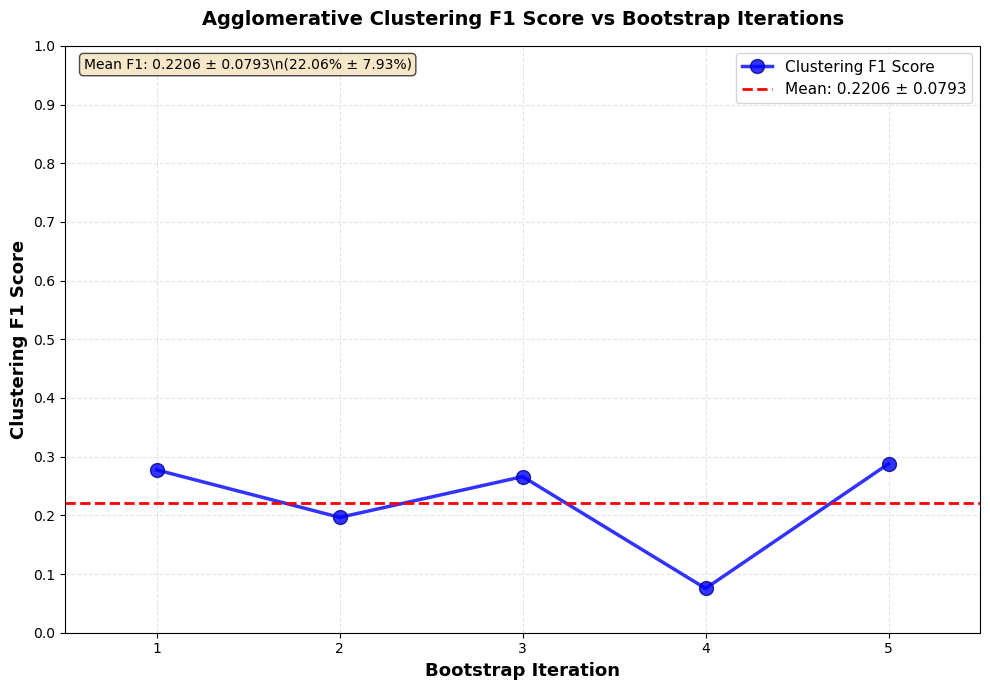

\n======================================================================
CLUSTERING F1 SCORE GRAPH DATA
\nResults:
  Bootstrap 1: F1=0.277372 (27.7372%)
  Bootstrap 2: F1=0.196532 (19.6532%)
  Bootstrap 3: F1=0.265957 (26.5957%)
  Bootstrap 4: F1=0.075472 (7.5472%)
  Bootstrap 5: F1=0.287879 (28.7879%)
\nStatistics:
  Mean F1: 0.220642 ± 0.079307
  Min F1: 0.075472 (7.5472%)
  Max F1: 0.287879 (28.7879%)


In [31]:
# ============================================================================
# GRAPH: Clustering F1 Scores vs Bootstrap Iterations
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np

# Check if clustering F1 data exists
if 'bootstrap_results' in locals() and len(bootstrap_results) > 0:
    # Extract clustering F1 scores
    clustering_f1_scores = []
    iterations = []
    
    for result in bootstrap_results:
        if 'clustering_f1' in result:
            clustering_f1_scores.append(result['clustering_f1'])
            iterations.append(result.get('iteration', len(iterations) + 1))
    
    if clustering_f1_scores:
        # Create the plot
        plt.figure(figsize=(10, 7))
        
        # Plot clustering F1 scores
        plt.plot(iterations, clustering_f1_scores, 'o-', 
                linewidth=2.5, markersize=10, color='blue', 
                markerfacecolor='blue', markeredgecolor='darkblue', 
                label='Clustering F1 Score', alpha=0.8)
        
        # Add mean line
        mean_f1 = np.mean(clustering_f1_scores)
        std_f1 = np.std(clustering_f1_scores)
        plt.axhline(y=mean_f1, color='red', linestyle='--', 
                   linewidth=2, label=f'Mean: {mean_f1:.4f} ± {std_f1:.4f}')
        
        # Formatting
        plt.xlabel('Bootstrap Iteration', fontsize=13, fontweight='bold')
        plt.ylabel('Clustering F1 Score', fontsize=13, fontweight='bold')
        plt.title('Agglomerative Clustering F1 Score vs Bootstrap Iterations', 
                 fontsize=14, fontweight='bold', pad=15)
        plt.grid(True, alpha=0.3, linestyle='--')
        plt.legend(fontsize=11, loc='best')
        
        # Set axis limits
        plt.xlim(0.5, len(iterations) + 0.5)
        plt.ylim(0, min(max(clustering_f1_scores) * 1.2, 1.05))
        
        # Set ticks
        plt.xticks(iterations)
        plt.yticks(np.arange(0, 1.1, 0.1))
        
        # Add text annotation with summary stats
        plt.text(0.02, 0.98, 
                f'Mean F1: {mean_f1:.4f} ± {std_f1:.4f}\\n({mean_f1*100:.2f}% ± {std_f1*100:.2f}%)', 
                transform=plt.gca().transAxes, fontsize=10,
                verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print("\\n" + "="*70)
        print("CLUSTERING F1 SCORE GRAPH DATA")
        print("="*70)
        print(f"\\nResults:")
        for i, (iter_num, f1) in enumerate(zip(iterations, clustering_f1_scores), 1):
            print(f"  Bootstrap {iter_num}: F1={f1:.6f} ({f1*100:.4f}%)")
        
        print(f"\\nStatistics:")
        print(f"  Mean F1: {mean_f1:.6f} ± {std_f1:.6f}")
        print(f"  Min F1: {np.min(clustering_f1_scores):.6f} ({np.min(clustering_f1_scores)*100:.4f}%)")
        print(f"  Max F1: {np.max(clustering_f1_scores):.6f} ({np.max(clustering_f1_scores)*100:.4f}%)")
        print("="*70)
        
    else:
        print("="*70)
        print("NO CLUSTERING F1 DATA FOUND")
        print("="*70)
        print("Clustering F1 scores not found in bootstrap_results.")
        print("Please ensure clustering code is integrated and bootstrap evaluation has been run.")
        print("="*70)
        
else:
    print("="*70)
    print("BOOTSTRAP RESULTS NOT FOUND")
    print("="*70)
    print("Please run the bootstrap evaluation first.")
    print("="*70)


Graphs

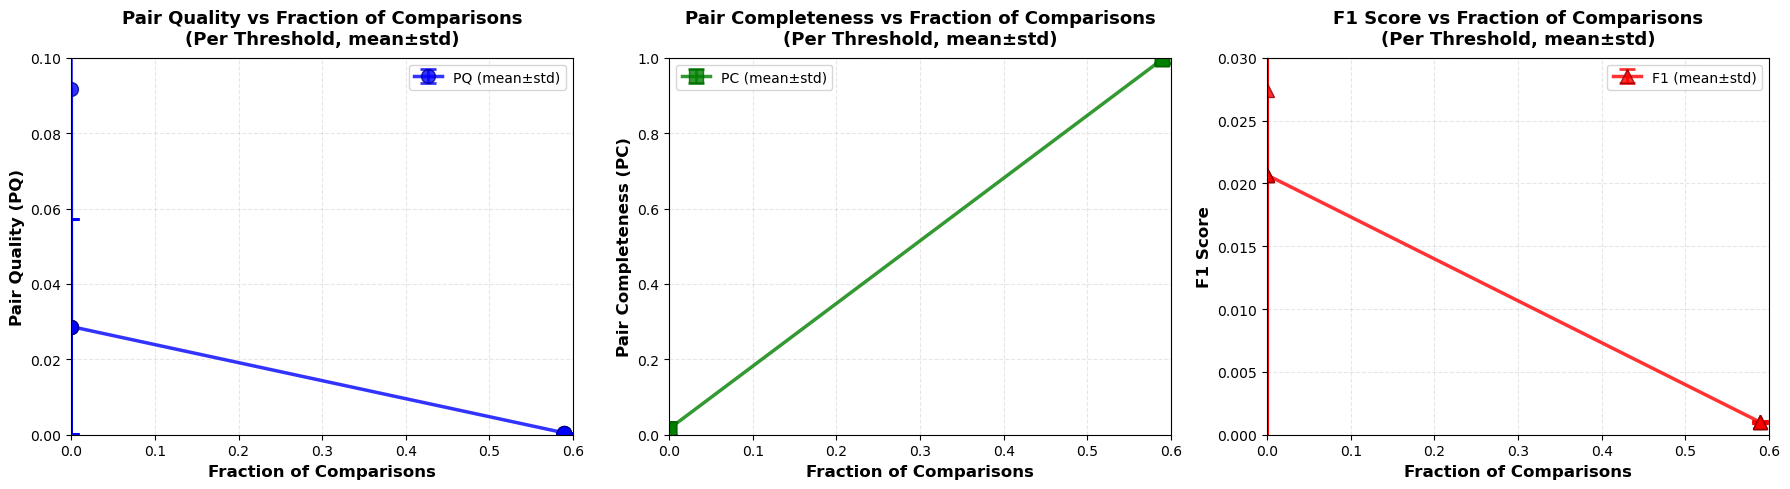

GRAPH DATA SUMMARY - PER THRESHOLD (mean±std)

Data points: 9 (one per threshold)
Each point shows mean ± std across all bootstrap iterations

Threshold    Frac. Comp.     PQ (mean±std)        PC (mean±std)        F1 (mean±std)       
--------------------------------------------------------------------------------
0.10         0.589387        0.000502±0.000036  0.995455±0.009091  0.001004±0.000071
0.20         0.589387        0.000502±0.000036  0.995455±0.009091  0.001004±0.000071
0.30         0.589387        0.000502±0.000036  0.995455±0.009091  0.001004±0.000071
0.40         0.589387        0.000502±0.000036  0.995455±0.009091  0.001004±0.000071
0.50         0.000169        0.028674±0.028435  0.016176±0.016648  0.020654±0.020975
0.60         0.000169        0.028674±0.028435  0.016176±0.016648  0.020654±0.020975
0.70         0.000169        0.028674±0.028435  0.016176±0.016648  0.020654±0.020975
0.80         0.000169        0.028674±0.028435  0.016176±0.016648  0.020654±0.020975
0.90

In [33]:
# ============================================================================
# GRAPHS: Per Threshold - PC, PQ, and F1 vs Fraction of Comparisons
# ============================================================================
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# Check if bootstrap_results exists
if 'bootstrap_results' in locals() and len(bootstrap_results) > 0:
    # Calculate fraction of comparisons for each result
    for result in bootstrap_results:
        test_size = result.get('test_size', 0)
        candidate_pairs = result.get('candidate_pairs', 0)
        
        if test_size > 0:
            total_possible_pairs = test_size * (test_size - 1) / 2
            fraction_of_comparisons = candidate_pairs / total_possible_pairs if total_possible_pairs > 0 else 0.0
            result['fraction_of_comparisons'] = fraction_of_comparisons
        else:
            result['fraction_of_comparisons'] = 0.0
    
    # Group by threshold and calculate mean/std across bootstrap iterations
    threshold_data = defaultdict(lambda: {'fractions': [], 'PQ': [], 'PC': [], 'F1': []})
    
    for result in bootstrap_results:
        threshold = result.get('threshold', 0)
        threshold_data[threshold]['fractions'].append(result.get('fraction_of_comparisons', 0))
        threshold_data[threshold]['PQ'].append(result.get('PQ', 0))
        threshold_data[threshold]['PC'].append(result.get('PC', 0))
        threshold_data[threshold]['F1'].append(result.get('F1', 0))
    
    # Calculate means and stds for each threshold
    thresholds_sorted = sorted(threshold_data.keys())
    frac_mean = np.array([np.mean(threshold_data[t]['fractions']) for t in thresholds_sorted])
    PQ_mean = np.array([np.mean(threshold_data[t]['PQ']) for t in thresholds_sorted])
    PC_mean = np.array([np.mean(threshold_data[t]['PC']) for t in thresholds_sorted])
    F1_mean = np.array([np.mean(threshold_data[t]['F1']) for t in thresholds_sorted])
    PQ_std = np.array([np.std(threshold_data[t]['PQ']) for t in thresholds_sorted])
    PC_std = np.array([np.std(threshold_data[t]['PC']) for t in thresholds_sorted])
    F1_std = np.array([np.std(threshold_data[t]['F1']) for t in thresholds_sorted])
    
    # Sort by fraction for plotting
    sort_idx = np.argsort(frac_mean)
    frac_sorted = frac_mean[sort_idx]
    PQ_mean_sorted = PQ_mean[sort_idx]
    PC_mean_sorted = PC_mean[sort_idx]
    F1_mean_sorted = F1_mean[sort_idx]
    PQ_std_sorted = PQ_std[sort_idx]
    PC_std_sorted = PC_std[sort_idx]
    F1_std_sorted = F1_std[sort_idx]
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # ========================================================================
    # SCALING CONFIGURATION - Modify these values to change graph scales
    # ========================================================================
    # Option 1: Automatic scaling (multiplier for padding)
    x_padding = 1.15  # Multiplier for x-axis (1.15 = 15% padding above max)
    y_padding = 1.15  # Multiplier for y-axis (1.15 = 15% padding above max)
    
    # Option 2: Fixed scaling (uncomment and set specific values)
    # x_max_fixed = 0.7      # Fixed maximum for x-axis (Fraction of Comparisons)
    # y_pq_max_fixed = 0.3   # Fixed maximum for PQ y-axis
    # y_pc_max_fixed = 1.1   # Fixed maximum for PC y-axis
    # y_f1_max_fixed = 0.1   # Fixed maximum for F1 y-axis
    
    # Calculate automatic scaling (if not using fixed values)
    max_frac = max(frac_sorted) if len(frac_sorted) > 0 else 1.0
    max_pq = max(PQ_mean_sorted + PQ_std_sorted) if len(PQ_mean_sorted) > 0 else 1.0
    max_pc = max(PC_mean_sorted + PC_std_sorted) if len(PC_mean_sorted) > 0 else 1.0
    max_f1 = max(F1_mean_sorted + F1_std_sorted) if len(F1_mean_sorted) > 0 else 1.0
    
    # Use fixed values if defined, otherwise use automatic
    x_max = x_max_fixed if 'x_max_fixed' in locals() else max_frac * x_padding
    y_pq_max = y_pq_max_fixed if 'y_pq_max_fixed' in locals() else max_pq * y_padding
    y_pc_max = y_pc_max_fixed if 'y_pc_max_fixed' in locals() else max_pc * y_padding
    y_f1_max = y_f1_max_fixed if 'y_f1_max_fixed' in locals() else max_f1 * y_padding
    
    # Graph 1: Pair Quality (PQ) vs Fraction of Comparisons
    ax1 = axes[0]
    ax1.errorbar(frac_sorted, PQ_mean_sorted, yerr=PQ_std_sorted, 
                 fmt='o-', linewidth=2.5, markersize=10, color='blue', 
                 capsize=6, capthick=2, elinewidth=2, 
                 markerfacecolor='blue', markeredgecolor='darkblue',
                 label='PQ (mean±std)', alpha=0.8, zorder=2)
    ax1.set_xlabel('Fraction of Comparisons', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Pair Quality (PQ)', fontsize=12, fontweight='bold')
    ax1.set_title('Pair Quality vs Fraction of Comparisons\n(Per Threshold, mean±std)', 
                  fontsize=13, fontweight='bold', pad=10)
    ax1.grid(True, alpha=0.3, linestyle='--')
    ax1.legend(fontsize=10, loc='best')
    ax1.set_xlim(0, 0.6)
    ax1.set_ylim(0, 0.1)
    
    # Graph 2: Pair Completeness (PC) vs Fraction of Comparisons
    ax2 = axes[1]
    ax2.errorbar(frac_sorted, PC_mean_sorted, yerr=PC_std_sorted, 
                 fmt='s-', linewidth=2.5, markersize=10, color='green', 
                 capsize=6, capthick=2, elinewidth=2,
                 markerfacecolor='green', markeredgecolor='darkgreen',
                 label='PC (mean±std)', alpha=0.8, zorder=2)
    ax2.set_xlabel('Fraction of Comparisons', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Pair Completeness (PC)', fontsize=12, fontweight='bold')
    ax2.set_title('Pair Completeness vs Fraction of Comparisons\n(Per Threshold, mean±std)', 
                  fontsize=13, fontweight='bold', pad=10)
    ax2.grid(True, alpha=0.3, linestyle='--')
    ax2.legend(fontsize=10, loc='best')
    ax2.set_xlim(0, 0.6)
    ax2.set_ylim(0, 1)
    
    # Graph 3: F1 Score vs Fraction of Comparisons
    ax3 = axes[2]
    ax3.errorbar(frac_sorted, F1_mean_sorted, yerr=F1_std_sorted, 
                 fmt='^-', linewidth=2.5, markersize=10, color='red', 
                 capsize=6, capthick=2, elinewidth=2,
                 markerfacecolor='red', markeredgecolor='darkred',
                 label='F1 (mean±std)', alpha=0.8, zorder=2)
    ax3.set_xlabel('Fraction of Comparisons', fontsize=12, fontweight='bold')
    ax3.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    ax3.set_title('F1 Score vs Fraction of Comparisons\n(Per Threshold, mean±std)', 
                  fontsize=13, fontweight='bold', pad=10)
    ax3.grid(True, alpha=0.3, linestyle='--')
    ax3.legend(fontsize=10, loc='best')
    ax3.set_xlim(0, 0.6)
    ax3.set_ylim(0, 0.03)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("="*80)
    print("GRAPH DATA SUMMARY - PER THRESHOLD (mean±std)")
    print("="*80)
    print(f"\nData points: {len(thresholds_sorted)} (one per threshold)")
    print(f"Each point shows mean ± std across all bootstrap iterations")
    print(f"\n{'Threshold':<12} {'Frac. Comp.':<15} {'PQ (mean±std)':<20} {'PC (mean±std)':<20} {'F1 (mean±std)':<20}")
    print("-" * 80)
    for i, t in enumerate(thresholds_sorted):
        # Find the index in sorted array
        orig_idx = np.where(sort_idx == i)[0][0] if i < len(sort_idx) else i
        print(f"{t:<12.2f} {frac_mean[i]:<15.6f} "
              f"{PQ_mean[i]:.6f}±{PQ_std[i]:.6f}  "
              f"{PC_mean[i]:.6f}±{PC_std[i]:.6f}  "
              f"{F1_mean[i]:.6f}±{F1_std[i]:.6f}")
    
    print(f"\nNote: Points are sorted by Fraction of Comparisons for plotting")
    print("="*80)
    
else:
    print("="*80)
    print("BOOTSTRAP RESULTS NOT FOUND")
    print("="*80)
    print("Please run the bootstrap evaluation first.")
    print("="*80)